In [ ]:
%cd '/content/drive/MyDrive/Colab Notebooks/stepik/m3. unsupervised/w4. topic modeling/4.4.2 postnauka'

In [2]:
!pip install bigartm

# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.9.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)).

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [3]:
import artm

In [4]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [5]:
import numpy as np
import pandas as pd
import random

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [6]:
batch_vectorizer = artm.BatchVectorizer(data_path="lectures.txt", 
    data_format="vowpal_wabbit", target_folder='batches', batch_size=100)

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [7]:
T = 30   # количество тем
topic_names = ["sbj" + str(i) for i in range(T - 1)] + ["bcg"]
class_ids = {'text': 1.0, 'author': 1.0}
np.random.seed(1)
model = artm.ARTM(num_topics=T, topic_names=topic_names, class_ids=class_ids, 
    seed=1, cache_theta=True, reuse_theta=True)

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [8]:
dictionary = artm.Dictionary('PostnaukaDictionary')
dictionary.gather(data_path=batch_vectorizer.data_path)
model.initialize(dictionary=dictionary)

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [9]:
model.scores.add(artm.TopTokensScore(name="TextTopTokensScore", num_tokens=15, class_id="text"))
model.scores.add(artm.TopTokensScore(name="AuthorTopTokensScore", num_tokens=15, class_id="author"))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [10]:
model.regularizers.add(artm.SmoothSparsePhiRegularizer(
    dictionary='PostnaukaDictionary', tau=1e5, class_ids='text', 
    topic_names='bcg'))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [11]:
model.num_document_passes = 1
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [12]:
model.regularizers.add(artm.SmoothSparsePhiRegularizer(
    dictionary='PostnaukaDictionary', tau=-1e5, class_ids='text', 
    topic_names=topic_names[:-1]))

Выполните еще 15 проходов по коллекции.

In [13]:
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [14]:
def print_tokens(tokens):
    for topic, items in tokens.items():
        print(f'{topic}: {" ".join(items)}')

topic_tokens = model.score_tracker["TextTopTokensScore"].last_tokens
print('Топы слов')
print_tokens(topic_tokens)

Топы слов
sbj0: частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
sbj1: материал температура структура вещество химический соединение свойство поверхность химия давление углерод сверхпроводимость металл применение полимер
sbj2: политический государство политика царь партия власть правитель враг сага кризис ритуал шмитт государь средневековый египетский
sbj3: знание университет образование школа предмет восприятие познание факультет аргумент студент логика кафедра прикладной концепт гумбольдт
sbj4: мозг ребенок нейрон мышление предложение категория взрослый чтение лицо синтаксический синтаксис устный обезьяна детство словосочетание
sbj5: бог миф греческий герой море мифология грек мифологический гусейнов персонаж шумерский гасан божество сущность генеалогия
sbj6: русский город текст городской перевод корпус гласный документ говор москва пьеса горожанин немецкий древнерусский метро
sbj7: трудность раса празд

In [15]:
print('Топы авторов')
print_tokens(model.score_tracker["AuthorTopTokensScore"].last_tokens)

Топы авторов
sbj0: Дмитрий_Казаков Михаил_Данилов Виктор_Брагута Сергей_Майоров Павел_Пахлов Игорь_Волобуев Валерий_Рубаков Сергей_Троицкий Лев_Дудко Анатолий_Лиходед Эдуард_Боос Лев_Беклемишев Роман_Мизюк Сергей_Кетов Жан-Арыс_Джилкибаев
sbj1: Артем_Оганов Валерий_Фокин Дмитрий_Паращук Валентин_Ненайденко Дмитрий_Гольберг Евгений_Гудилин Владимир_Пудалов Валентин_Крапошин Иван_Сорокин Наталья_Берлофф Вадим_Бражкин Алексей_Кавокин Дмитрий_Клинов Сергей_Морозов Пётр_Образцов
sbj2: Алексей_Юдин Михаил_Бойцов Дина_Гусейнова Татьяна_Смоктунович Иван_Ладынин Андрей_Лукашов Зоригто_Намсараев Владимир_Малахов Кирилл_Мартынов Руслан_Хестанов Ольга_Тогоева Фёдор_Успенский Юрий_Рогулёв Владимир_Кузнецов Александр_Филиппов
sbj3: Виктор_Вахштайн Наталья_Ростиславлева Татьяна_Клячко Григорий_Крейдлин Максим_Демин Дмитрий_Балалыкин Сергей_Зенкин Алексей_Котов Татьяна_Котова Илья_Иткин Александр_Пиперски Елена_Брызгалина Алексей_Руткевич Мария_Фаликман Борис_Миркин
sbj4: Филипп_Хайтович Александр_Кап

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [16]:
sbj_topic_labels = [v[0].capitalize() for v in list(topic_tokens.values())[:-1]]
topic_labels = sbj_topic_labels + ["Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [17]:
model.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
theta = model.get_theta()
phi_a = model.get_phi(class_ids='author')

Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

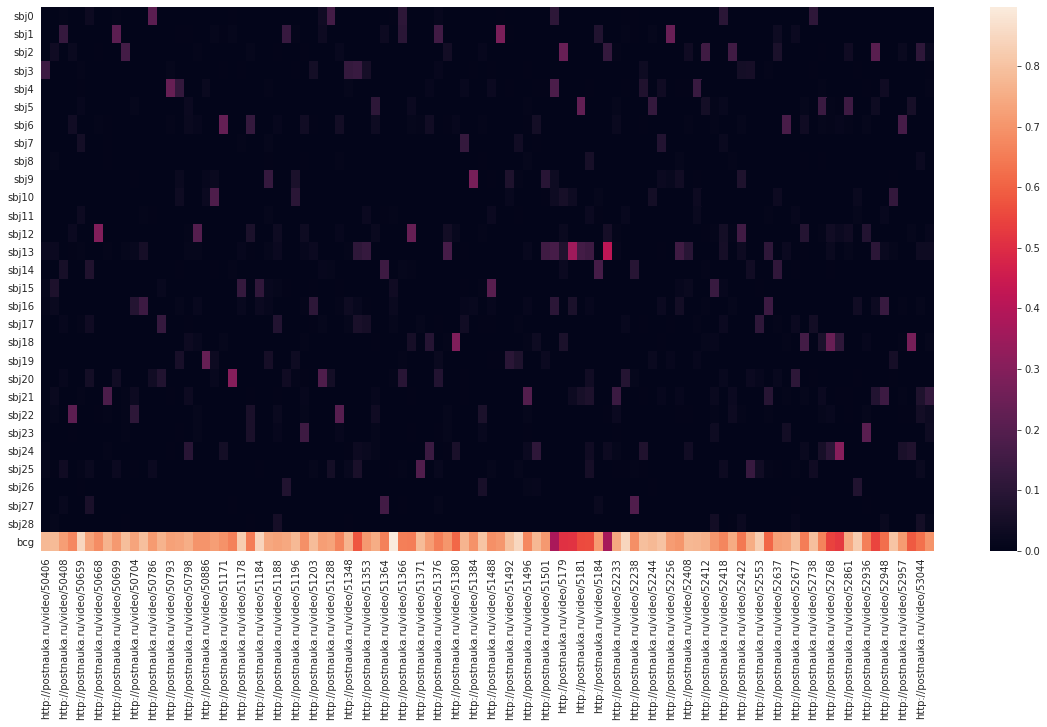

In [18]:
plt.figure(figsize=(20, 10))
seaborn.heatmap(theta.iloc[:,:100])
plt.show()

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [19]:
topic_probs = pd.DataFrame()
topic_probs['p'] = theta.sum(axis=1) / theta.shape[1]
topic_probs.index = topic_labels
topic_probs

,p
Частица,0.009680
Материал,0.014885
Политический,0.009870
Знание,0.006364
Мозг,0.006584
Бог,0.006359
Русский,0.007615
Трудность,0.004714
Право,0.008077
Болезнь,0.010671


Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

In [20]:
topic_probs.sort_values(by='p', ascending=False, inplace=True)
print(' '.join(topic_probs.index[2:7].values))
print(' '.join(topic_probs.index[-3:].values))

Клетка Энергия Животное Язык Галактика
Память Трудность Внимание


Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

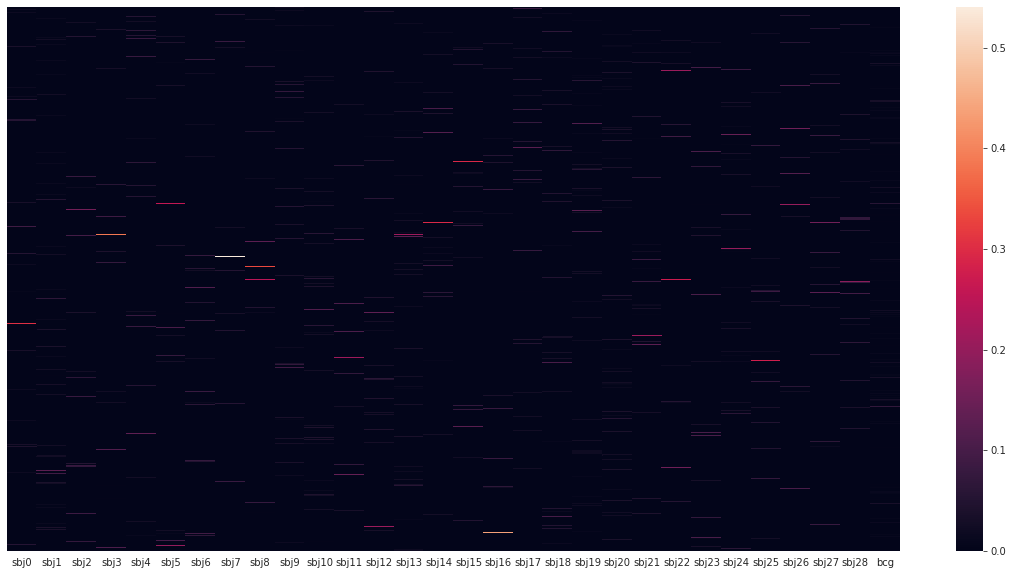

In [21]:
plt.figure(figsize=(20, 10))
seaborn.heatmap(phi_a, yticklabels=False)
plt.show()

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [22]:
significance_count = (phi_a > 0.01).sum(axis=1)
print(' '.join(significance_count[significance_count > 2].index))

Андрей_Журавлев Ольга_Вайнштейн Фёдор_Успенский Олег_Ауров Александр_Пиперски Илья_Иткин


Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [23]:
topic_profile = phi_a * topic_probs.values.reshape(-1)
author_probs = topic_profile.sum(axis=1)
topic_profile = (topic_profile.T / author_probs).T.values

In [24]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

distances = pairwise_distances(topic_profile, metric='cosine')
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=0)
topic_profile_points = mds.fit_transform(distances)

Визуализируйте найденные двумерные представления с помощью функции scatter. 

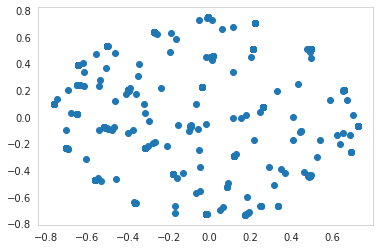

In [25]:
plt.scatter(topic_profile_points[:, 0], topic_profile_points[:, 1])
plt.show()

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

In [ ]:
!pip install adjustText
from adjustText import adjust_text

In [27]:
def reduce_author_names(anames):
    reduced_names = []
    for an in anames:
        if an.find('_') != -1:
            items = an.split('_')
            reduced_names.append(items[0][:2] + '.' + '.'.join(items[1:]))
        else:
            reduced_names.append(an)
    return reduced_names

<font color=red>Выполнение следующей ячейки в Google Colab занимает около 15 минут</font>

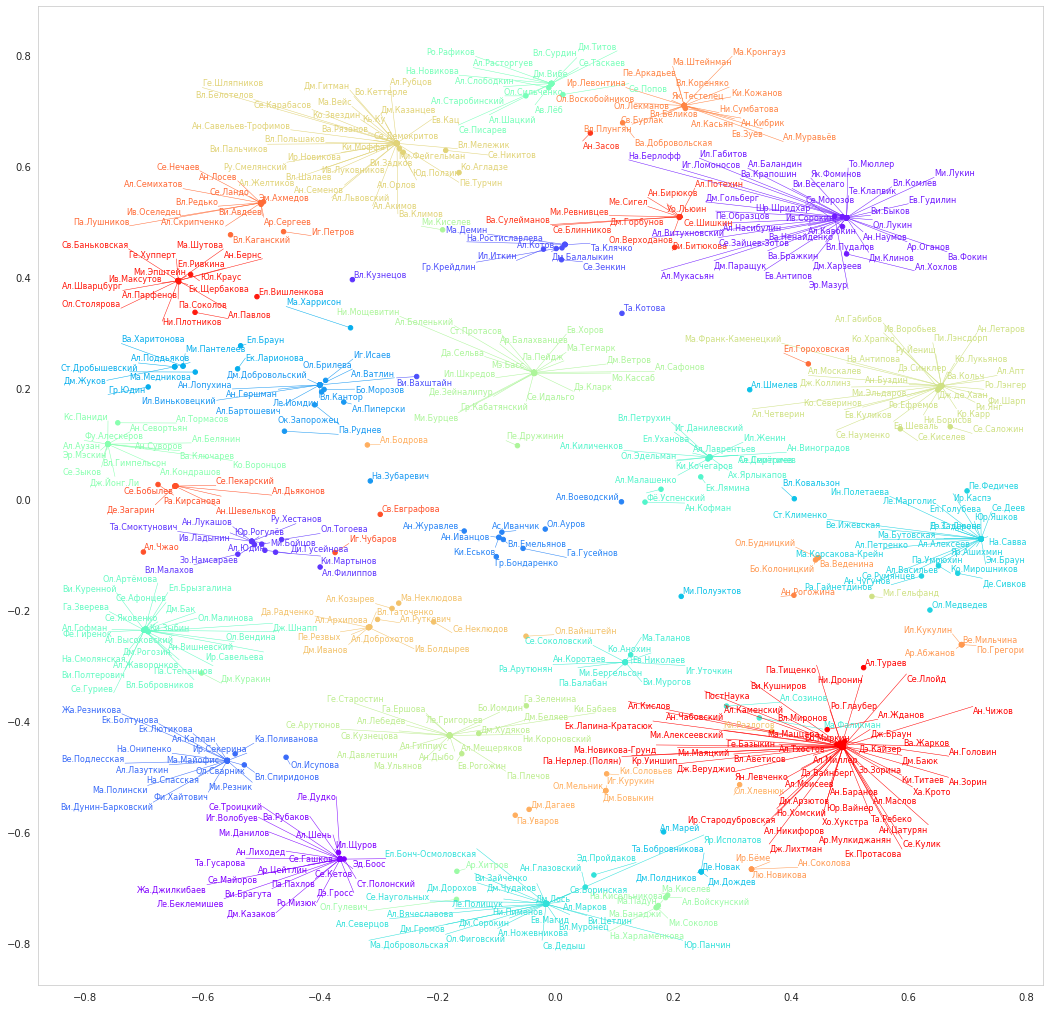

In [28]:
import matplotlib.cm as cm
cmap = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
fig, ax = plt.subplots(figsize=(18, 18))
n = topic_profile_points.shape[0]
xcoords, ycoords = topic_profile_points[:n, 0], topic_profile_points[:n, 1]
authors = reduce_author_names(phi_a.index.values[:n])
colors = cmap[np.argmax(topic_profile, axis=1)[:n]]
ax.scatter(xcoords, ycoords, s=20, c=colors)
pack = zip(xcoords, ycoords, authors, colors)
texts = [ax.text(x, y, a, c=c, size=8) for x, y, a, c in pack]
adjust_text(texts)
for x, y, t, c in zip(xcoords, ycoords, texts, colors):
    tx, ty = t.get_position()
    if x != tx or y != ty:
        plt.plot([x, tx], [y, ty], c=c, linewidth=0.5)
plt.savefig('authors_map.pdf', format='pdf')
plt.show()

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [31]:
doc_topic_distr = (theta.T / theta.sum(axis=1)).T

Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [32]:
print("http://yandex.ru")   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [33]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [36]:
for header, tokens, theta_row in zip(sbj_topic_labels, topic_tokens.values(), theta.values):
    display(HTML(f'<hr><h1>{header}</h1>'))
    print(' '.join(tokens[:10]))
    links = theta.columns[np.argsort(theta_row)[::-1][:10]].values
    display(HTML('<br>'))
    for l in links:
        print(l)#display(HTML(f'<li><a href = {l}>{l}<a></li>'))
    display(HTML('<br>'))


частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон


http://postnauka.ru/video/13043
http://postnauka.ru/video/18870
http://postnauka.ru/video/18873
http://postnauka.ru/video/47950
http://postnauka.ru/video/2945
http://postnauka.ru/video/11634
http://postnauka.ru/video/1894
http://postnauka.ru/video/47175
http://postnauka.ru/video/14282
http://postnauka.ru/video/478


материал температура структура вещество химический соединение свойство поверхность химия давление


http://postnauka.ru/video/31182
http://postnauka.ru/video/13700
http://postnauka.ru/video/57995
http://postnauka.ru/video/18048
http://postnauka.ru/video/41686
http://postnauka.ru/video/13544
http://postnauka.ru/video/51490
http://postnauka.ru/video/50340
http://postnauka.ru/video/46379
http://postnauka.ru/video/56295


политический государство политика царь партия власть правитель враг сага кризис


http://postnauka.ru/video/5517
http://postnauka.ru/video/5179
http://postnauka.ru/video/32906
http://postnauka.ru/video/13538
http://postnauka.ru/video/52941
http://postnauka.ru/video/32882
http://postnauka.ru/video/12083
http://postnauka.ru/video/56304
http://postnauka.ru/video/59199
http://postnauka.ru/video/53228


знание университет образование школа предмет восприятие познание факультет аргумент студент


http://postnauka.ru/video/2973
http://postnauka.ru/video/31198
http://postnauka.ru/video/19570
http://postnauka.ru/video/35038
http://postnauka.ru/video/55533
http://postnauka.ru/video/49445
http://postnauka.ru/video/40889
http://postnauka.ru/video/55217
http://postnauka.ru/video/50406
http://postnauka.ru/video/3603


мозг ребенок нейрон мышление предложение категория взрослый чтение лицо синтаксический


http://postnauka.ru/video/50793
http://postnauka.ru/video/55068
http://postnauka.ru/video/12521
http://postnauka.ru/video/47548
http://postnauka.ru/video/26207
http://postnauka.ru/video/5178
http://postnauka.ru/video/25891
http://postnauka.ru/video/27965
http://postnauka.ru/video/36350
http://postnauka.ru/video/7767


бог миф греческий герой море мифология грек мифологический гусейнов персонаж


http://postnauka.ru/video/43664
http://postnauka.ru/video/5181
http://postnauka.ru/video/27831
http://postnauka.ru/video/42796
http://postnauka.ru/video/31990
http://postnauka.ru/video/21637
http://postnauka.ru/video/46427
http://postnauka.ru/video/12527
http://postnauka.ru/video/36716
http://postnauka.ru/video/47300


русский город текст городской перевод корпус гласный документ говор москва


http://postnauka.ru/video/13156
http://postnauka.ru/video/51171
http://postnauka.ru/video/8964
http://postnauka.ru/video/24279
http://postnauka.ru/video/48112
http://postnauka.ru/video/24945
http://postnauka.ru/video/47301
http://postnauka.ru/video/57318
http://postnauka.ru/video/23470
http://postnauka.ru/video/10773


трудность раса праздник шаман америка станислав африка тест нос монголоид


http://postnauka.ru/video/31707
http://postnauka.ru/video/37732
http://postnauka.ru/video/32898
http://postnauka.ru/video/35150
http://postnauka.ru/video/42707
http://postnauka.ru/video/15341
http://postnauka.ru/video/42735
http://postnauka.ru/video/17397
http://postnauka.ru/video/31675
http://postnauka.ru/video/40880


право римский правовой юрист суд юридический сон должник собственность обязательство


http://postnauka.ru/video/9299
http://postnauka.ru/video/38009
http://postnauka.ru/video/34414
http://postnauka.ru/video/49455
http://postnauka.ru/video/17912
http://postnauka.ru/video/16822
http://postnauka.ru/video/42221
http://postnauka.ru/video/31688
http://postnauka.ru/video/31666
http://postnauka.ru/video/17875


болезнь заболевание пациент лечение медицина врач боль препарат медицинский иммунный


http://postnauka.ru/video/13746
http://postnauka.ru/video/532
http://postnauka.ru/video/7753
http://postnauka.ru/video/11361
http://postnauka.ru/video/12974
http://postnauka.ru/video/2541
http://postnauka.ru/video/49206
http://postnauka.ru/video/11850
http://postnauka.ru/video/45961
http://postnauka.ru/video/51384


животное робот растение вода организм микроорганизм нервный рецептор биологический эволюция


http://postnauka.ru/video/9861
http://postnauka.ru/video/30673
http://postnauka.ru/video/8953
http://postnauka.ru/video/2531
http://postnauka.ru/video/32635
http://postnauka.ru/video/7113
http://postnauka.ru/video/19071
http://postnauka.ru/video/25889
http://postnauka.ru/video/49437
http://postnauka.ru/video/10786


память информация когнитивный зрительный процесс запоминать психолог линзовидный воспроизводить картинка


http://postnauka.ru/video/9997
http://postnauka.ru/video/56052
http://postnauka.ru/video/54916
http://postnauka.ru/video/57336
http://postnauka.ru/video/37979
http://postnauka.ru/video/27845
http://postnauka.ru/video/38507
http://postnauka.ru/video/3645
http://postnauka.ru/video/17421
http://postnauka.ru/video/23079


империя германия историк церковь государственный русь святой военный российский великий


http://postnauka.ru/video/24034
http://postnauka.ru/video/3348
http://postnauka.ru/video/24039
http://postnauka.ru/video/32637
http://postnauka.ru/video/19574
http://postnauka.ru/video/23900
http://postnauka.ru/video/35041
http://postnauka.ru/video/50668
http://postnauka.ru/video/31183
http://postnauka.ru/video/34936


наука социальный рассказывать общество понятие исторический кандидат история социология каков


http://postnauka.ru/video/10783
http://postnauka.ru/video/10749
http://postnauka.ru/video/9148
http://postnauka.ru/video/7778
http://postnauka.ru/video/9870
http://postnauka.ru/video/17491
http://postnauka.ru/video/5878
http://postnauka.ru/video/3417
http://postnauka.ru/video/6380
http://postnauka.ru/video/5198


галактика планета земля звезда черный дыра масса газ атмосфера диск


http://postnauka.ru/video/2971
http://postnauka.ru/video/9835
http://postnauka.ru/video/31193
http://postnauka.ru/video/57338
http://postnauka.ru/video/31695
http://postnauka.ru/video/36249
http://postnauka.ru/video/3604
http://postnauka.ru/video/3423
http://postnauka.ru/video/58744
http://postnauka.ru/video/45644


решение экономический экономика деньги компания принятие ценность международный выбор ресурс


http://postnauka.ru/video/53415
http://postnauka.ru/video/5465
http://postnauka.ru/video/13152
http://postnauka.ru/video/24286
http://postnauka.ru/video/27823
http://postnauka.ru/video/28278
http://postnauka.ru/video/51488
http://postnauka.ru/video/26119
http://postnauka.ru/video/14280
http://postnauka.ru/video/43679


человек поведение психология психологический эмоция конфликт мужчина коллективный эмоциональный способность


http://postnauka.ru/video/22892
http://postnauka.ru/video/22883
http://postnauka.ru/video/26223
http://postnauka.ru/video/21643
http://postnauka.ru/video/9865
http://postnauka.ru/video/40866
http://postnauka.ru/video/9729
http://postnauka.ru/video/16191
http://postnauka.ru/video/21661
http://postnauka.ru/video/2946


задача данные компьютер сеть программа компьютерный алгоритм интеллект интернет искусственный


http://postnauka.ru/video/32901
http://postnauka.ru/video/24306
http://postnauka.ru/video/8313
http://postnauka.ru/video/33885
http://postnauka.ru/video/55303
http://postnauka.ru/video/47810
http://postnauka.ru/video/12172
http://postnauka.ru/video/9998
http://postnauka.ru/video/45717
http://postnauka.ru/video/13155


территория словарь восток древний письменность народ китай северный памятник восточный


http://postnauka.ru/video/53171
http://postnauka.ru/video/5891
http://postnauka.ru/video/59201
http://postnauka.ru/video/2527
http://postnauka.ru/video/12515
http://postnauka.ru/video/17041
http://postnauka.ru/video/51380
http://postnauka.ru/video/25290
http://postnauka.ru/video/52958
http://postnauka.ru/video/56302


клетка ген днк белок организм молекула генетический геном бактерия рнк


http://postnauka.ru/video/5390
http://postnauka.ru/video/10475
http://postnauka.ru/video/17051
http://postnauka.ru/video/27434
http://postnauka.ru/video/32881
http://postnauka.ru/video/35461
http://postnauka.ru/video/35051
http://postnauka.ru/video/5915
http://postnauka.ru/video/16156
http://postnauka.ru/video/11628


энергия квантовый поле магнитный атом электрон свет волна эффект фотон


http://postnauka.ru/video/19457
http://postnauka.ru/video/21662
http://postnauka.ru/video/25875
http://postnauka.ru/video/24434
http://postnauka.ru/video/19509
http://postnauka.ru/video/51174
http://postnauka.ru/video/3381
http://postnauka.ru/video/23335
http://postnauka.ru/video/26609
http://postnauka.ru/video/18221


культура философия философский философ автор женщина произведение платон роман религиозный


http://postnauka.ru/video/2529
http://postnauka.ru/video/12738
http://postnauka.ru/video/7764
http://postnauka.ru/video/9728
http://postnauka.ru/video/53513
http://postnauka.ru/video/23834
http://postnauka.ru/video/32664
http://postnauka.ru/video/7068
http://postnauka.ru/video/46317
http://postnauka.ru/video/37965


революция власть король французский реформа петр франция против сталин император


http://postnauka.ru/video/53577
http://postnauka.ru/video/48492
http://postnauka.ru/video/54175
http://postnauka.ru/video/47823
http://postnauka.ru/video/1893
http://postnauka.ru/video/25882
http://postnauka.ru/video/42993
http://postnauka.ru/video/58542
http://postnauka.ru/video/23161
http://postnauka.ru/video/50656


советский россия война мировой гражданский песня союз обряд екатерина самка


http://postnauka.ru/video/34413
http://postnauka.ru/video/30261
http://postnauka.ru/video/46939
http://postnauka.ru/video/52936
http://postnauka.ru/video/57259
http://postnauka.ru/video/41680
http://postnauka.ru/video/25890
http://postnauka.ru/video/55219
http://postnauka.ru/video/47816
http://postnauka.ru/video/25906


язык христианский литературный литература лингвист христианство глагол филологический лингвистика языковой


http://postnauka.ru/video/7755
http://postnauka.ru/video/13041
http://postnauka.ru/video/10473
http://postnauka.ru/video/55301
http://postnauka.ru/video/52778
http://postnauka.ru/video/3387
http://postnauka.ru/video/14297
http://postnauka.ru/video/53169
http://postnauka.ru/video/49203
http://postnauka.ru/video/16157


теория пространство математический описывать уравнение матрица теоретический математика описание эйнштейн


http://postnauka.ru/video/3388
http://postnauka.ru/video/36804
http://postnauka.ru/video/57128
http://postnauka.ru/video/55069
http://postnauka.ru/video/18085
http://postnauka.ru/video/18086
http://postnauka.ru/video/19456
http://postnauka.ru/video/51371
http://postnauka.ru/video/25278
http://postnauka.ru/video/34416


внимание костюм коллективизация фразеологизм скелет сочетание банк финансовый термоэлектрический порнография


http://postnauka.ru/video/9389
http://postnauka.ru/video/31684
http://postnauka.ru/video/43843
http://postnauka.ru/video/49866
http://postnauka.ru/video/40004
http://postnauka.ru/video/37978
http://postnauka.ru/video/36242
http://postnauka.ru/video/57127
http://postnauka.ru/video/30601
http://postnauka.ru/video/26616


звезда вселенная объект излучение белый нейтронный карлик спектр вещество телескоп


http://postnauka.ru/video/53693
http://postnauka.ru/video/6673
http://postnauka.ru/video/30015
http://postnauka.ru/video/59202
http://postnauka.ru/video/23969
http://postnauka.ru/video/49447
http://postnauka.ru/video/10756
http://postnauka.ru/video/12372
http://postnauka.ru/video/38007
http://postnauka.ru/video/23500


фильм роль свобода кино кинематограф культовый академия академический профессор бердяев


http://postnauka.ru/video/5396
http://postnauka.ru/video/9429
http://postnauka.ru/video/10779
http://postnauka.ru/video/39723
http://postnauka.ru/video/11246
http://postnauka.ru/video/8623
http://postnauka.ru/video/7074
http://postnauka.ru/video/57126
http://postnauka.ru/video/19436
http://postnauka.ru/video/45548


##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 